<a href="https://colab.research.google.com/github/zar55/COSC_635_Reinforcement_Learning/blob/main/Lab_06_zziauddin1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COSC-635: Lab 6

**Zargham Ziauddin**


## Getting Started

Follow the instructions below to set copy this notebook and to perform some initial setup.

1. Copy this notebook by selecting `File > Save a copy in Drive`.
2. A new window should open for the copied notebook. Move the new notebook to your course folder in Google Drive by selecting `File > Move` and then selecting the desired folder.
3. Update the name of the notebook by removing "Copy of" and replacing "Username" with your actual username.
4. Update the first cell in the notebook by specifying your course number (435 or 635) and by replacing "Student Name" with your actual name.
5. Mount your Google Drive by running the cell below and accepting the prompts you are presented with.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preparing the Colab Environment

Run the cell below to install gymnasium and to download rltools to the virtual machine.

In [ ]:
%%capture
!pip install swig
!pip install gymnasium[box2d]==0.28.1
!pip install "stable-baselines3[extra]==2.0.0"
!rm rltools -r
!git clone https://github.com/drbeane/rltools.git

The cell below includes the import statements that you will need for this assignmnet.

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import rltools.gym as gym
from rltools.utils import RandomAgent, SB3Agent
from rltools.utils import create_gif, evaluate, sb3_evaluation_curves

from stable_baselines3 import DQN

from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


## Note on Variable Names

You are free to select the variable names for the objects that you create in this notebook. But please make sure that the variable names you select in Part 1 are distinct from those used in Part 2. An exception to this rule can be made in instances where a particular variable will be used in a single cell, but no where else in the notebook.

## GPU Acceleration

GPU acceleration will be helpful for some parts of this assignment. Specifically, the code in 3.C will likely run about twice a fast on a GPU as compared to a CPU. The rest of the notebook, however, can be run on CPU with no issues.

Google Colab provides free GPU access, but this usage is subject to a daily limit. In order to preserve your GPU hours, I would recommend not enabling the GPU until you are ready to run code in 3.C.

The GPU can be enabled by going to `Runtime > Change runtime type`. You should have `T4 GPU` selected.

Keep in mind that changing the runtime type does reset your kernal, so you will need to re-run the cells at the start of the notebok after enabling the GPU.

# Part 1 - Mountain Car Environment

In Part 1 of this assignment, you will train a DQN agent on a vectorized version of the Mountain Car environment. The main purpose of this part is to familiarize you with the usage of vectorized environments.

Mountain Car is a relatively simple environment. The goal of the environment is to guide a car out from the bottom of a valley to the top of a hill by applying acceleration in one of two directions. The environment has 3 actions: 0 (accelerate left), 1 (don't accelerate), and 2 (accelerate right). The action space consists of two continuous values. The first value represents the horizontal position of the car and the second represents the car's velocity. The agent receives a time step penalty of -1 for each action taken, and is thus encouraged to reach the top of the hill as quickly as possible.

You can find more information about this environment here: [Gymnasium Documentation: Mountain Car](https://gymnasium.farama.org/environments/classic_control/mountain_car/)



## 1.A - Create Environment

Use the cell below to create a non-vectorized instance of the environment. Then use `matplotlib` to display the initial state of the environment (without axes). We will use this version of the environment only for the purpose of exporing the performance of a random agent.

Starting State: [-0.50829965  0.        ]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


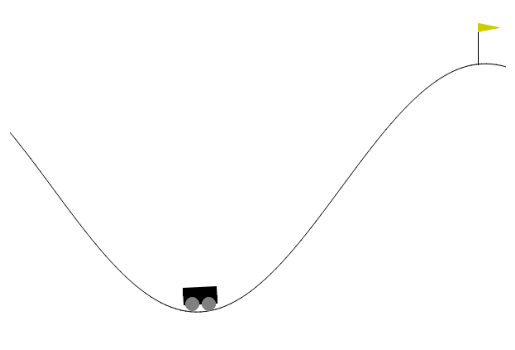

In [ ]:
mc_env = gym.make(name = 'MountainCar-v0', render_mode = 'rgb_array')

state, info = mc_env.reset()
print(f'Starting State: {state}')

plt.imshow(mc_env.render())
plt.axis('off')
plt.show()

## 1.B - Evaluate Random Agent

Complete the following steps in the cell below:
1. Create an instance of `RandomAgent` for the environment created in 1.A.
2. Evaluate the random agent's performance using the `evaluate()` function. Set `episodes=50`, `max_steps=200`, `gamma=1.0`, and `seed=1`.



In [ ]:
mc_random = RandomAgent(env = mc_env)

mc_eval = evaluate(env = mc_env,
                   agent = mc_random,
                   gamma = 1.0,
                   episodes = 50,
                   max_steps = 200,
                   seed = 1)


Mean Return:    -200.0
StdDev Return:  0.0
Mean Length:    200.0
StdDev Length:  0.0


## 1.C - Visualize Random Agent Behavior

Use the `create_gif()` function to create a gif demonstrating an episode generated by the random agent. Set `seed=1` and `max_steps=200`.

200 steps completed.
Cumulative reward: -200.0


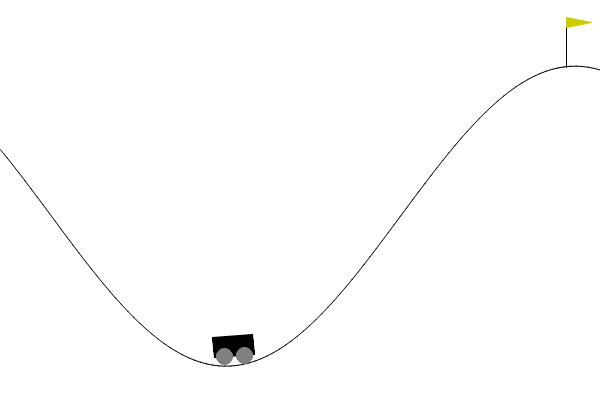

In [ ]:
create_gif(env = mc_env,
           agent = mc_random,
           seed = 1,
           max_steps = 200,
           folder = 'gifs',
           filename = 'mc_non_vec')

## 1.D - Create Vectorized Environments

Complete the following steps in the cell below:
1. Use the `make_vec_env()` function to create two vectorized versions of the mountain car environment, each containing 4 copies of the underyling environment. One vectorized environment will be the "base" environment used for training, and the other will be use for evaluation.
2. Create a non-vectorized version of the environment to be used for testing purposes.
3. Display the initial state of the base environment (without axes). You should see an image with 4 copies of the underlying environment, with the car in a slightly different position in each copy.


(4, 2)


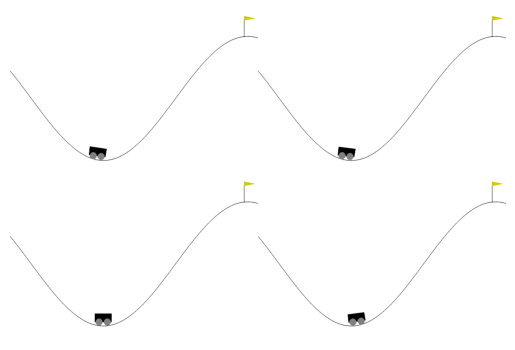

In [ ]:
mc_base_env = make_vec_env(env_id = 'MountainCar-v0', n_envs = 4)
mc_eval_env = make_vec_env(env_id = 'MountainCar-v0', n_envs = 4)

mc_env = gym.make(name = 'MountainCar-v0', render_mode = 'rgb_array')

state = mc_base_env.reset()
print(state.shape)

plt.imshow(mc_base_env.render())
plt.axis('off')
plt.show()

## 1.E - Create Evaluation Callback

In the cell below, create an `EvalCallback` object using the evaluation environment. Set the callback to run the evualation every 1000 time steps using 20 episodes for each evaluation. Set `warn=False`.

**Note: You will create two evaluation callbacks in this notebook. You should use different names for the directories associated with these callbacks.**

In [ ]:
if os.path.exists('mc_evaluation/') : shutil.rmtree('mc_evaluation')
mc_eval_callback = EvalCallback(mc_eval_env,
                                best_model_save_path = 'mc_evaluation/',
                                log_path = 'mc_evaluation',
                                eval_freq = 1000,
                                n_eval_episodes = 20,
                                warn = False)

## 1.F - Build and Train Model

Use the cell below to create a instance of `DQN` and train it on the vectorized environemnt. Starter code has been provided. You need to complete the parts of the starter code that have been left blank.

**Your goal is to train an agent that gets a mean return of -105 or higher.**

The starter code provides values for several `DQN` parameters. The network architecture (as definied by `policy_kwargs`) has not been provided. You should experiment with the architecture of the network. A good rule of thumb is to use 2-3 hidden layers, with the numbers of nodes within those layers being equal to powers of 2. You can also adjust the other parameters, if you wish, but there is a satisfactory solution that uses the parameter values provided.

Train the model using the callback created in Step 1.E. It should be possible to meet the goal in 200,000 time steps or less, and it should take less than 5 minutes to train the agent.

Note that until the agent learns to reach the top of the hill, it will consistently get a mean return of -200. This will make it appear as though the agent is not learning initially. Depending on your parameter selection, it might take 100,000 time-steps or more before the agent starts to generate returns greater than -200.






In [ ]:
%%time

model = DQN(
    policy = "MlpPolicy",
    env = mc_base_env,
    learning_rate = 4e-3,

    batch_size = 128,
    buffer_size = 10_000,
    learning_starts = 0,

    gamma = 0.98,
    target_update_interval = 600,
    train_freq = 16,
    gradient_steps = 8,

    exploration_fraction = 0.2,
    exploration_initial_eps = 1.0,
    exploration_final_eps = 0.07,

    policy_kwargs = dict(net_arch=[256,256]),
    verbose=0,
    seed=1
)

model = model.learn(total_timesteps=200_000, callback=mc_eval_callback)

Eval num_timesteps=4000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=8000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=12000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=16000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=20000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=24000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=28000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=32000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=36000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=44000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00

## 1.G - Plot the Evaluation Results

Use the `sb3_evaluation_curves()` function to generate plots illustrating the progression of the scores for the evaluation environment during training. Specify a value for `path`, but leave the default values for the other parameters.

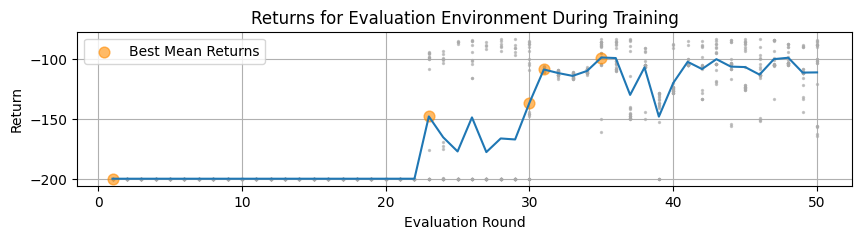

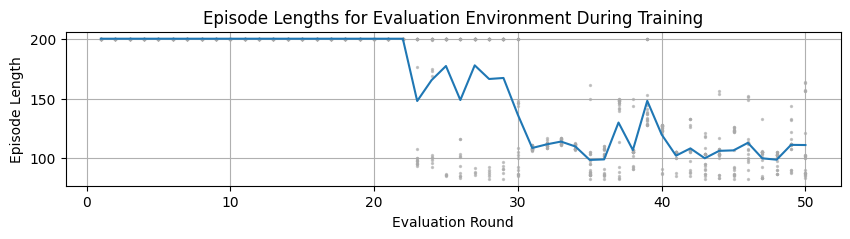

In [ ]:
sb3_evaluation_curves(path = 'mc_evaluation/')

## 1.H - Load and Evaluate the Best Model

Use the cell below to load the best model encountered during training, passing the test environment to the `env` parameter for the `DQN.load()` method. Create an instance of `SB3Agent` using this model. Then use the `evaluate()` function to score the model, setting `gamma=1.0`, `episodes=50`, and `max_steps=200`.

**Your model should have a mean return of -105 or greater.** If it does not, then you will need to adjust the parameters in part 1.F and train the model again. You should re-run the cells in 1.D and 1.E before re-running 1.F.

In [ ]:
mc_best = DQN.load(path = 'mc_evaluation/best_model.zip', env = mc_env)

mc_sb3 = SB3Agent(model = mc_best)

mc_eval = evaluate(env = mc_env, agent = mc_sb3, gamma = 1.0, episodes = 50, max_steps = 200)

Mean Return:    -102.26
StdDev Return:  18.787
Mean Length:    102.26
StdDev Length:  18.787


## 1.I - Visualize Agent Behavior

Use the `create_gif()` function to display an episode guided by the trained DQN agent. Set `seed=1` and `max_steps=200`. **Select a seed that results in an episode with a score of -105 or greater.**

103 steps completed.
Cumulative reward: -103.0


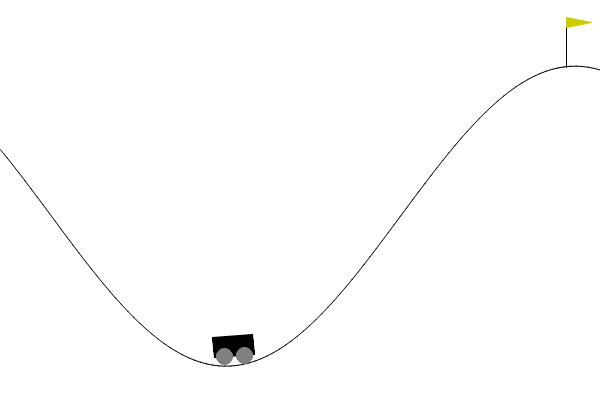

In [ ]:
create_gif(env = mc_env, agent = mc_sb3, seed = 1, max_steps = 200, folder = 'gifs', filename = 'mc', display_gif = True)

# Part 2 - Lunar Lander Environment

In Part 2 of this assignment, you will train a DQN agent from scratch on a vectorized version of the lunar lander environment. Your goal will be to find a model that achieves a mean return of at least 250.

## 2.A - Create Environments

Use the `make_vec_env()` function to create two vectorized versions of the lunar lander environment, each containing 8 copies of the underlying environment. One vectorized environment will be the "base" environment used for training, and the other will be use for evaluation.

Also create a non-vectorized version of the lunar lander environment for testing purposes.


(8, 8)


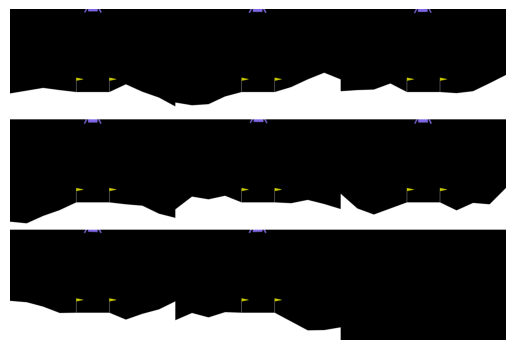

In [ ]:
ll_base_env = make_vec_env(env_id = 'LunarLander-v2', n_envs = 8)
ll_eval_env = make_vec_env(env_id = 'LunarLander-v2', n_envs = 8)

ll_env = gym.make(name = 'LunarLander-v2', render_mode = 'rgb_array')

state = ll_base_env.reset()
print(state.shape)

plt.imshow(ll_base_env.render())
plt.axis('off')
plt.show()

## 2.B - Create Evaluation Callback

In the cell below, create an `EvalCallback` object using the evaluation environment. Set the callback to run the evalation every 1000 time steps, using 20 episodes for each evaluation. Set `warn=False`.

**Note: You will create two evaluation callbacks in this notebook. You should use different names for the directories associated with these callbacks.**

In [ ]:
if os.path.exists('ll_evaluation/') : shutil.rmtree('ll_evaluation/')

ll_eval_callback = EvalCallback(ll_eval_env,
                                best_model_save_path = 'll_evaluation',
                                log_path = 'll_evaluation',
                                n_eval_episodes = 20,
                                eval_freq = 1000,
                                warn = False)

## 2.C - Build and Train Model

Use the cell below to create a instance of `DQN` and train it on the "base" vectorized environment. Starter code has been provided. You need to complete the parts of the starter code that have been left blank.

**Your goal is to train an agent that gets a mean return of 250 or higher.**

The starter code provides values for several `DQN` parameters. You can experiment with the parameters if you would like, but these parameters should result in a satisfactory solution.

Train the model for 300_000 timesteps using the callback created in Step 2.B.

**As mentioned earlier in this notebook, training this model will likely be quicker if using a GPU rather than a CPU.** Runtimes can vary based on many factors (such as traffic levels on Colab), but the cell below will likely take about 50 minutes to run on CPU and about 30 minutes on a T4 GPU.





In [ ]:
%%time

ll_model = DQN(
    policy = "MlpPolicy",
    env = ll_base_env,
    learning_rate = 7e-4,

    batch_size = 128,
    buffer_size = 100_000,
    learning_starts = 0,

    gamma = 0.99,
    target_update_interval = 250,
    train_freq = 1,
    gradient_steps = 4,

    exploration_fraction = 0.08,
    exploration_initial_eps = 1.0,
    exploration_final_eps = 0.05,

    policy_kwargs = dict(net_arch=[256, 256]),
    verbose=0,
    seed=1,
)

ll_model = ll_model.learn(total_timesteps= 300_000, callback= ll_eval_callback)

Eval num_timesteps=8000, episode_reward=-75.14 +/- 50.61
Episode length: 341.85 +/- 177.34
New best mean reward!
Eval num_timesteps=16000, episode_reward=-142.60 +/- 31.97
Episode length: 456.30 +/- 91.34
Eval num_timesteps=24000, episode_reward=-13.64 +/- 20.65
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=32000, episode_reward=-19.66 +/- 28.05
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-30.79 +/- 67.98
Episode length: 951.70 +/- 146.78
Eval num_timesteps=48000, episode_reward=-136.43 +/- 93.36
Episode length: 889.30 +/- 232.34
Eval num_timesteps=56000, episode_reward=-13.49 +/- 27.84
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=64000, episode_reward=-65.81 +/- 60.24
Episode length: 876.85 +/- 293.27
Eval num_timesteps=72000, episode_reward=32.76 +/- 80.55
Episode length: 835.50 +/- 283.89
New best mean reward!
Eval num_timesteps=80000, episode_reward=91.15 +/- 222.16
Episode length: 466.40 +/- 238

## 2.D - Plot the Evaluation Results

Use the `sb3_evaluation_curves()` function to generate plots illustrating the progression of the scores for the evaluation environment during training. Specify a value for `path`, but leave the default values for the other parameters.

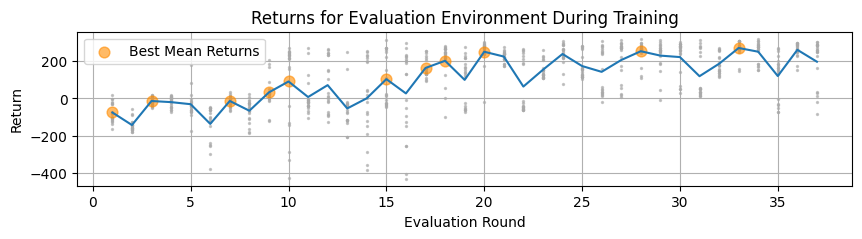

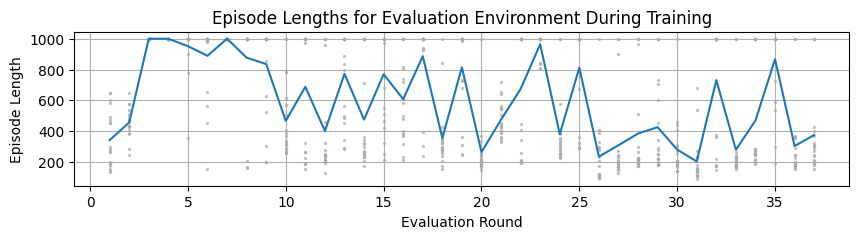

In [ ]:
sb3_evaluation_curves(path = 'll_evaluation/')

## 2.E - Load and Evaluate the Best Model

Use the cell below to load the best model encountered during training, passing the test environment to the `env` parameter for the `DQN.load()` method. Create an instance of `SB3Agent` using this model. Then use the `evaluate()` function to score the model, setting `gamma=1.0`, `episodes=50`, and `max_steps=1000`.

**Your model should have a mean return of at least 250.** If it does not, then you will need to adjust the parameters in part 2.C and train the model again. You should re-run the cells in 2.A and 2.B before re-running 2.C.**

In [ ]:
ll_best = DQN.load(path = 'll_evaluation/best_model.zip', env = ll_env)

ll_sb3 = SB3Agent(model = ll_best)

ll_eval = evaluate(env = ll_env, agent = ll_sb3, gamma = 1.0, episodes = 50, max_steps = 1000)

Mean Return:    262.6004
StdDev Return:  45.9505
Mean Length:    269.8
StdDev Length:  200.9615


## 2.F - Visualize Agent Behavior

Use the `create_gif()` function to display an episode guided by the trained DQN agent. Set `seed=1` and `max_steps=1000`. **Select a seed that results in an episode with a score of 250 or greater.**

183 steps completed.
Cumulative reward: 278.5879


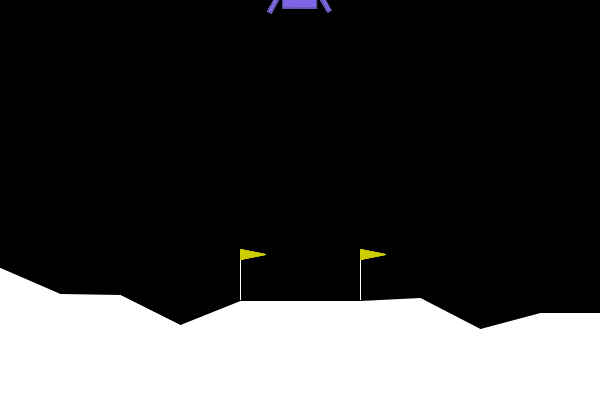

In [ ]:
create_gif(env = ll_env, agent = ll_sb3, seed = 1, max_steps = 1000, folder = 'gifs', filename = 'll', display_gif = True)

# Important Note about Submissions

The training process for SB3 models involves many stochastic elements, and these elements come from different packages that have their own random number generators. In most cases, it is very difficult, and sometimes impossible, to use seeds to guarantee fully deterministic behavior.

One consequence of this relates to Parts 1.I and 2.F above. Suppose you find seed values that meets the criteria detailed in those parts. When you re-run the notebook for submission, your model might be slightly different, and your previous seed might not work any longer.

**After re-running your notebook for submission, you should check 1.I and 2.F to confirm that the current seed values are still satisfactory.** If they are not, then you can change the seeds and re-run this cell as needed. When you have found a satisfactory seed, you can re-run the last cell of the notebook to create a new HTML render for your notebook.

# Submission Instructions

1. The cell below will generate an HTML render of your notebook within the same Google Drive folder in which you stored this notebook. Adjust the path for your notebook in the cell below as needed.
2. Restart your notebook and run it from start to finish.
3. If the notebook executes without error, download the HTML export of the notebook and then upload it to Canvas. Make sure to carefully review the contents of the HTML export to ensure that everything is displayed correctly.
4. Click on "Share" in the upper-right corner of this notebook. Then select "Anyone with the link" from dropdown. Click "Copy Link" and paste the copied link as a comment in your submission on Canvas.


In [ ]:
#%%capture
import time
time.sleep(60)
!jupyter nbconvert --to html /content/drive/MyDrive/COSC_635/Lab_06_zziauddin1.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/COSC_635/Lab_06_zziauddin1.ipynb to html
[NbConvertApp] Writing 1967365 bytes to /content/drive/MyDrive/COSC_635/Lab_06_zziauddin1.html
